In [1]:
# !pip install -q flwr[simulation]
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached aiohttp-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached aiohttp_cors-0.7.0-py3-none-any.whl (27 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Using cached blessed-1.20.0-py2.py3-none-any.whl (58 kB)
  Using cached cachetools-5.3.0-py3-none-any.whl (9.3 kB)
  Using cached certifi-2023.5.7-py3-none-any.whl (156 kB)
  Using cached charset_normalizer-3.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (199 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached cmake-3.26.3-py2.py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (24.0 MB)
  Using cached colorful-0.5.5-py2.py3-none-any.whl (201 kB)
  Using cached DateTime-5.1-py3-none-any.whl (52 kB)
  Using cached distlib-0.3.6-py2.py3-none-any.whl

# Content table

## Installing dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import datetime
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import color
import os
import multiprocessing as mp
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cores = mp.cpu_count()
c = color.clr()
print(c.SUCCESS('Day:'), datetime.datetime.now())
print(c.SUCCESS('Device:'), device)
print(c.SUCCESS('Core:'), cores)

/home/quachnam/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Day: 2023-05-24 10:21:26.553897
Device: cpu
Core: 8


# Step 0: Preparation

## Loading the data

In [7]:
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
NUM_CLIENTS = 10
BATCH_SIZE = 32

In [8]:
def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader
trainloaders, valloaders, testloader = load_datasets()

100%|██████████| 170498071/170498071 [00:04<00:00, 36385187.90it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


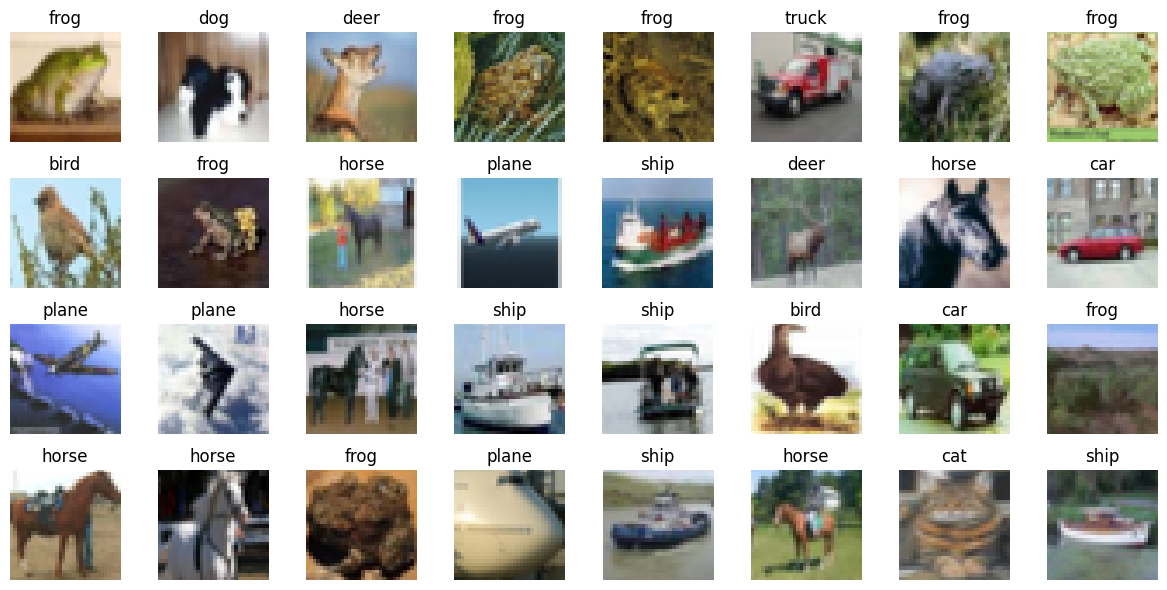

In [9]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

# Step 1: Centralized Training with PyTorch

## Defining the model

In [10]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

## Training the model

In [14]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(device)

for epoch in range(20):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)

Epoch 1: validation loss 0.06004124736785889, accuracy 0.312
Epoch 2: validation loss 0.05779955625534058, accuracy 0.316
Epoch 3: validation loss 0.054870599508285524, accuracy 0.412
Epoch 4: validation loss 0.052472200393676754, accuracy 0.404
Epoch 5: validation loss 0.05205818915367127, accuracy 0.434
Epoch 6: validation loss 0.05231433224678039, accuracy 0.424
Epoch 7: validation loss 0.04919330954551697, accuracy 0.448
Epoch 8: validation loss 0.04966213226318359, accuracy 0.448
Epoch 9: validation loss 0.04915183448791504, accuracy 0.458
Epoch 10: validation loss 0.04959049725532532, accuracy 0.46
Epoch 11: validation loss 0.052406489849090576, accuracy 0.442
Epoch 12: validation loss 0.05305424880981445, accuracy 0.456
Epoch 13: validation loss 0.048916202068328855, accuracy 0.492
Epoch 14: validation loss 0.0508643901348114, accuracy 0.458
Epoch 15: validation loss 0.052021794080734256, accuracy 0.468
Epoch 16: validation loss 0.05708535885810852, accuracy 0.456
Epoch 17: vali

# Step 2: Federated Learning with Flower

## Updating model parameters

In [18]:
def get_parameters(net):
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

## Implementing a Flower client

In [19]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

## Using the Virtual Client Engine

In [20]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(device)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

## Starting the training

In [21]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if device.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-05-22 09:52:04,854 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-05-22 09:52:11,012	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-05-22 09:52:16,959 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 7888785408.0, 'object_store_memory': 3944392704.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 7888785408.0, 'object_store_memory': 3944392704.0, 'CPU': 2.0}
INFO flwr 2023-05-22 09:52:16,969 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-05-22 09:52:16,988 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=7315) 2023-05-22 09:52:21.879752: W tensorflow/compiler/t

KeyboardInterrupt: ignored

## Behind the scenes

## Where’s the accuracy?

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)